# Comparison of training results

In [1]:
import wandb
import pandas as pd
from pathlib import Path
import json
import datasets
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tqdm.auto import tqdm

from evaluation.plotting import set_size
import matplotlib.pyplot as plt

plt.style.use("../../thesis.mplstyle")

In [2]:
PATH_LATEX_TABLE_OUTPUT = Path(
    "../../thesis/from_python/tables/classification/training_results/"
)
PATH_LATEX_PLOT_OUTPUT = Path(
    "../../thesis/from_python/figures/classification/training_results/"
)

PATH_LATEX_TABLE_OUTPUT.mkdir(exist_ok=True, parents=True)
PATH_LATEX_PLOT_OUTPUT.mkdir(exist_ok=True, parents=True)

In [3]:
ds = datasets.load_dataset("paul-ww/ei-abstract-significance")
df_test = ds["test"].to_pandas()

In [46]:
df_train = ds["train"].to_pandas()
df_val = ds["validation"].to_pandas()
df_splits = pd.concat(
    [df_train, df_val, df_test], keys=["train", "val", "test"]
).reset_index(names=["split", "index"])

pd.crosstab(df_splits["label"], df_splits["split"], margins=True).rename_axis(
    None, axis=0
).rename_axis(None, axis=1).rename(
    index={0: r"\textit{no significant effect}", 1: r"\textit{significant effect}"}
).rename(
    columns={"test": "Test", "train": "Train", "val": "Validation"}
)[
    ["Train", "Validation", "Test", "All"]
].style.applymap_index(
    lambda v: "font-weight: bold;", axis="columns"
).to_latex(
    PATH_LATEX_TABLE_OUTPUT / "dataset_splits.tex",
    hrules=True,
    siunitx=True,
    convert_css=True,
    column_format="lS[table-format=4.0]S[table-format=3.0]S[table-format=3.0]|S[table-format=4.0]",
)

In [4]:
wandb.login()
api = wandb.Api()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: paul_ww. Use `wandb login --relogin` to force relogin


In [6]:
RUN_GROUPS = {
    "Baseline (Tf-Idf+LR)": "baseline",
    "PubMedBERT": "transformer_finetuned",
    "PubMedBERT-SetFit": "transformer_setfit",
    "Zero-Shot (BART)": "transformer_zero_shot",
}

In [7]:
summary_metrics = {}
proba_predictions = {}

for i, (desc, run_group) in enumerate(
    tqdm(RUN_GROUPS.items(), desc="Saving plots / tables")
):
    runs = api.runs(
        path="paul_ww/significance_classification",
        filters={"group": run_group},
        order="-summary_metrics.test.macro_avg_f1-score",
    )
    best_run = runs[0]
    run_artifacts = best_run.logged_artifacts()
    test_probas = next(filter(lambda a: "test_probas" in a.name, run_artifacts))
    test_probas.download()
    download_path = Path(test_probas.file())
    probs = json.loads(download_path.read_text())

    df_probs = pd.DataFrame(
        columns=[
            "prob_not_significant",
            "prob_significant",
        ],  # the column descriptions on the artifacts are reversed :-(
        data=probs["data"],
    )
    df_probs["y_pred"] = (
        df_probs["prob_significant"] > df_probs["prob_not_significant"]
    ).astype(int)
    df_summ = pd.DataFrame(best_run.summary_metrics["test"])

    summary_metrics[desc] = df_summ
    proba_predictions[desc] = df_probs
    # df_summ.style.to_latex(
    #     PATH_LATEX_TABLE_OUTPUT / f"summary_{run_group}.tex", hrules=True, siunitx=True
    # )

Saving plots / tables:   0%|          | 0/4 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [8]:
pd.concat(summary_metrics)

significant effect  no significant effect  \
Baseline (Tf-Idf+LR) recall               0.878049               0.390244   
                     support             82.000000              41.000000   
                     f1-score             0.804469               0.477612   
                     precision            0.742268               0.615385   
PubMedBERT           recall               0.804878               0.756098   
                     support             82.000000              41.000000   
                     f1-score             0.835443               0.704545   
                     precision            0.868421               0.659574   
PubMedBERT-SetFit    f1-score             0.683230               0.400000   
                     precision            0.696203               0.386364   
                     recall               0.670732               0.414634   
                     support             82.000000              41.000000   
Zero-Shot (BART)     precision            0.757009               0.937500   
                     recall               0.987805               0.365854   
                     support             82.000000              41.000000   
                     f1-score             0.857143               0.526316   

                                accuracy   macro avg  weighted avg  
Baseline (Tf-Idf+LR) recall     0.715447    0.634146      0.715447  
                     support    0.715447  123.000000    123.000000  
                     f1-score   0.715447    0.641041      0.695517  
                     precision  0.715447    0.678826      0.699974  
PubMedBERT           recall     0.788618    0.780488      0.788618  
                     support    0.788618  123.000000    123.000000  
                     f1-score   0.788618    0.769994      0.791811  
                     precision  0.788618    0.763998      0.798806  
PubMedBERT-SetFit    f1-score   0.585366    0.541615      0.588820  
                     precision  0.585366    0.541283      0.592923  
                     recall     0.585366    0.542683      0.585366  
                     support    0.585366  123.000000    123.000000  
Zero-Shot (BART)     precision  0.780488    0.847255      0.817173  
                     recall     0.780488    0.676829      0.780488  
                     support    0.780488  123.000000    123.000000  
                     f1-score   0.780488    0.691729      0.746867

In [48]:
df_metrics = (
    pd.concat(summary_metrics)
    .T.stack()
    .loc["significant effect"]
    .T.rename(columns=lambda x: x.capitalize())
    .rename(columns={"F1-score": "$F_1$"})[["$F_1$", "Precision", "Recall"]]
    .style.highlight_max(axis=0, props="font-weight:bold;")
)
df_metrics.applymap_index(lambda v: "font-weight: bold;", axis="columns").to_latex(
    PATH_LATEX_TABLE_OUTPUT / "metric_comparison.tex",
    siunitx=True,
    hrules=True,
    convert_css=True,
    column_format="lS[table-format=1.2]S[table-format=1.2]S[table-format=1.2]",
)
df_metrics

,$F_1$,Precision,Recall
Baseline (Tf-Idf+LR),0.804469,0.742268,0.878049
PubMedBERT,0.835443,0.868421,0.804878
PubMedBERT-SetFit,0.683230,0.696203,0.670732
Zero-Shot (BART),0.857143,0.757009,0.987805


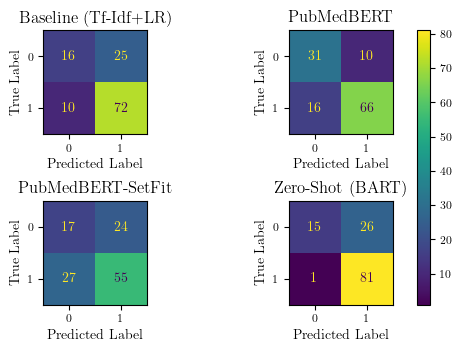

In [17]:
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import cm

fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=set_size("thesis", subplots=(2, 2)),
    # sharex=True,
    # sharey=True,
    constrained_layout=True,
)
axes = list(axs.flat)

# Calculate global min and max values across all matrices
cm_max = -np.inf
cm_min = np.inf

for i, desc in enumerate(RUN_GROUPS.keys()):
    matrix = confusion_matrix(
        y_true=df_test["label"], y_pred=proba_predictions[desc]["y_pred"]
    )
    cm_max = max(cm_max, np.max(matrix))
    cm_min = min(cm_min, np.min(matrix))

for i, desc in enumerate(RUN_GROUPS.keys()):
    matrix = confusion_matrix(
        y_true=df_test["label"], y_pred=proba_predictions[desc]["y_pred"]
    )
    disp = ConfusionMatrixDisplay(
        matrix,
        display_labels=[0, 1],
    )
    disp.plot(ax=axes[i], xticks_rotation=0, im_kw={"vmin": cm_min, "vmax": cm_max})
    disp.ax_.set_title(desc)
    disp.ax_.set_xlabel("Predicted Label")
    disp.ax_.set_ylabel("True Label")
    # disp.ax_.use_sticky_edges = False
    disp.im_.colorbar.remove()

norm = Normalize(vmin=cm_min, vmax=cm_max)
fig.colorbar(cm.ScalarMappable(norm=norm), ax=axs)
# fig.supxlabel("Predicted Label")
# fig.supylabel("True Label")
fig.savefig(str(PATH_LATEX_PLOT_OUTPUT / f"confusion_matrices.pdf"), dpi=300)

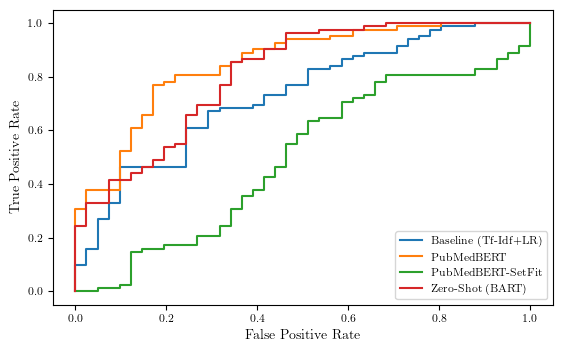

In [11]:
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=set_size("thesis"), constrained_layout=True)

for desc, df_proba in proba_predictions.items():
    fpr, tpr, _ = roc_curve(
        y_true=df_test["label"],
        y_score=df_proba["prob_significant"],
        pos_label=1,
    )
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    roc_display.plot(ax=ax, name=desc)
fig.savefig(str(PATH_LATEX_PLOT_OUTPUT / "roc_curves.pdf"))

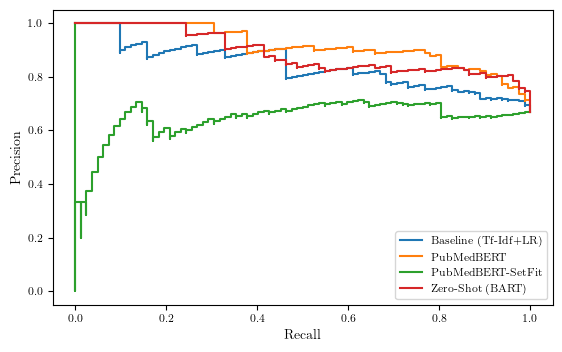

In [12]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=set_size("thesis"), constrained_layout=True)

for desc, df_proba in proba_predictions.items():
    precision, recall, _ = precision_recall_curve(
        y_true=df_test["label"],
        probas_pred=df_proba["prob_significant"],
        pos_label=1,
    )
    pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
    pr_display.plot(ax=ax, name=desc)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 0.0))
fig.savefig(str(PATH_LATEX_PLOT_OUTPUT / "pr_curves.pdf"))